March: Replicating wind-driven upwelling events.

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
import cmocean as cmo
from datetime import datetime
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

In [2]:
def load_month(filename):
    path = '../data/for_atmospheric_forcing/'
    data = sep95 = pd.read_csv(path+filename, skiprows=16, encoding='ISO-8859-1')
    return data

def convert_times(dates):
    times_all = []
    for ii in range(0, len(dates)):
        times_new = datetime.strptime(dates[ii], '%Y-%m-%d %H:%M')
        times_all.append(times_new)
    return times_all

def get_data_day(data, day):
    wind_speed = np.array(data['Wind Spd (km/h)'])
    wind_dir = np.array(data['Wind Dir (10s deg)']) #
    date_time = np.array(data['Date/Time'])
    day_index = np.where(data['Day']==day)   
    dates_day = convert_times(date_time[day_index])
    
    wind_speed_day = wind_speed[day_index] * 1000 / 3600
    wind_dir_day = wind_dir[day_index] * 10 #
    return dates_day, wind_speed_day, wind_dir_day

def get_data_range(data, days_start, days_end):
    n_hours = 24
    days_range = np.arange(days_start,days_end+1)
    wind_speed_range = np.zeros((len(days_range),n_hours))
    wind_dir_range = np.zeros_like(wind_speed_range) #
    dates_range = []
    for day, n in zip(days_range, np.arange(len(wind_speed_range))):
        dates_day, wind_speed_day, wind_dir_day = get_data_day(data, day) #
        wind_speed_range[n, :] = wind_speed_day
        wind_dir_range[n, :] = wind_dir_day #
        dates_range = np.append(dates_range, dates_day)
    wind_speed_range = wind_speed_range.flatten()
    wind_dir_range = wind_dir_range.flatten() #
    return dates_range, wind_speed_range, wind_dir_range

def convert_wind_stress(wind_speed_range):
    wind_stress_range = 1.25 * (1.5 * 10**-3) * (wind_speed_range**2)
    return wind_stress_range

def convert_angle_component(speed, angle):
    xcomp = -1 * speed * np.sin(np.deg2rad(angle))
    return xcomp

def combine_ranges(data_list, start_list, end_list):
    date_all = []
    speed_all = []
    stress_all = []

    for data, start, end in zip(data_list, start_list, end_list):
        dates, speed, direc = get_data_range(data, start, end) #
        stress = convert_wind_stress(speed)
        stress_x = convert_angle_component(stress, direc) #
        

        date_all = np.append(date_all, dates)
        speed_all = np.append(speed_all, speed)
        stress_all = np.append(stress_all, stress_x)
    
    return date_all, speed_all, stress_all

def plot_range(ax, dates, wind_stress, ymin = -0.3, ymax=0.3):
    ax.plot(dates, wind_stress, linewidth=1.5, color='royalblue')
    ax.set_ylabel('X Component of Wind Stress [Nm$^{-2}$]', fontsize=14)
    ax.yaxis.grid()
    ax.set_ylim([ymin, ymax])
    ax.axhline(0, c='k')
    return ax

def upwelling_event(ax, date_all, year, month, day, hr, label, inds, ev, y=0.2):
    if ev == 'upw':
        c = 'indianred'
    elif ev == 'wnd':
        c = 'indigo'
    elif ev == 'wnd2':
        c = 'orchid'
    elif ev == 'dta':
        c = 'darkgreen'
    else:
        c = 'k'
    ind = np.where(date_all == datetime(year, month, day, hr, 0))[0][0]
    ax.axvline(date_all[ind], color=c, linewidth=3.5)
    ax.text(date_all[ind-inds], y, label, rotation=90, fontsize=14)
    return ax

def wind_range(ax, date_all, year1, year2, month1, month2, day1, day2, label, ev):
    if ev == 'wnd':
        c = 'indigo'
    elif ev == 'wnd2':
        c = 'orchid'
    ind1 = np.where(date_all == datetime(year1, month1, day1, 0, 0))[0][0]
    ind2 = np.where(date_all == datetime(year2, month2, day2, 0, 0))[0][0]
    ax.hlines(y=0.25, xmin=date_all[ind1], xmax=date_all[ind2], color=c, linewidth=3.5)
    ax.text(date_all[ind1], 0.26, label, fontsize=14)
    return ax

def stress_max_min(ax, stress_all):
    max_stress = np.nanmax(stress_all)
    min_stress = np.nanmin(stress_all)
    ax.text(date_all[np.where(stress_all == max_stress)[0][0]], max_stress, str(np.round(max_stress,2)), fontsize=14)
    ax.text(date_all[np.where(stress_all == min_stress)[0][0]], min_stress, str(np.round(min_stress,2)), fontsize=14)
    return ax

In [3]:
sep87 = load_month('eng-hourly-09011987-09301987.csv')
oct87 = load_month('eng-hourly-10011987-10311987.csv')
nov87 = load_month('eng-hourly-11011987-11301987.csv')
sep95 = load_month('eng-hourly-09011995-09301995.csv')
oct95 = load_month('eng-hourly-10011995-10311995.csv')

# Previous Runs
    nn_tau000   =   86400s = 24 hr

    utau(:,:) = rn_utau0 =   -0.1
    vtau(:,:) = rn_vtau0 =    0.0

    IF( kt <= nn_tau000 ) THEN       
    utau(:,:) = ztx
    vtau(:,:) = zty         

    IF( kt > nn_tau000 ) THEN
    utau(:,:) = rn_utau0 * 0.05

In [26]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177/'
utau_o, vtau_o = functions_plot.load_model_other(path, 'Run08')

# Upwelling Event A

* 0.13 impulse lasting 48 hours with upwelling event starting at about the 13th day
* after impulse, wind stress drops to 0 with a few bumps

        nn_tau000  = 172800s = 48h
        rn_utau0 = -0.13
        rn_vtau0 = 0.0
        utau(:,:) = rn_utau0 * 0.0

Error at 4 hours:

    stpctl: the zonal velocity is larger than 20 m/s
    kt=  1450 max abs(U):   58.13    , i j k:   186  176    1

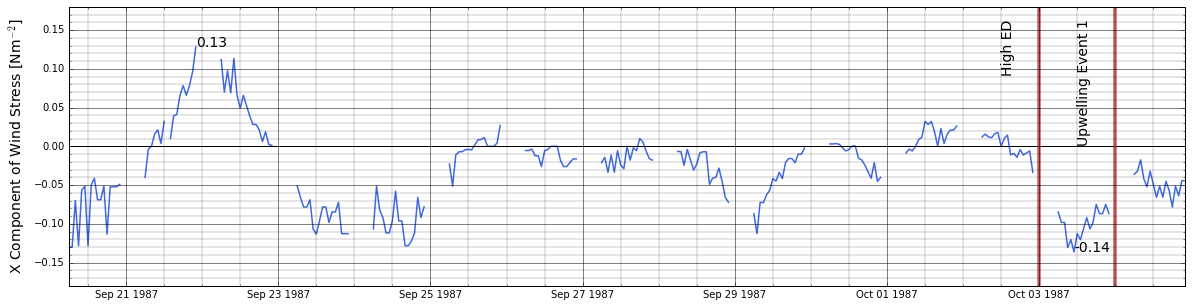

In [4]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
data_list = [sep87, oct87]
start_list = [20,1]
end_list = [30,4]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax = plot_range(ax, date_all, stress_all, -0.18, 0.18)
ax = stress_max_min(ax, stress_all)
ax = upwelling_event(ax, date_all, 1987, 10, 3, 0, 'High ED', 12, 'upw', 0.15)
ax = upwelling_event(ax, date_all, 1987, 10, 4, 0, 'Upwelling Event 1', 12, 'upw', 0.15)
ax.grid(b=True, which='major', color='k', linestyle='-', linewidth=0.5)
ax.grid(b=True, which='minor', color='k', linestyle='-', linewidth=0.2)
ax.minorticks_on()

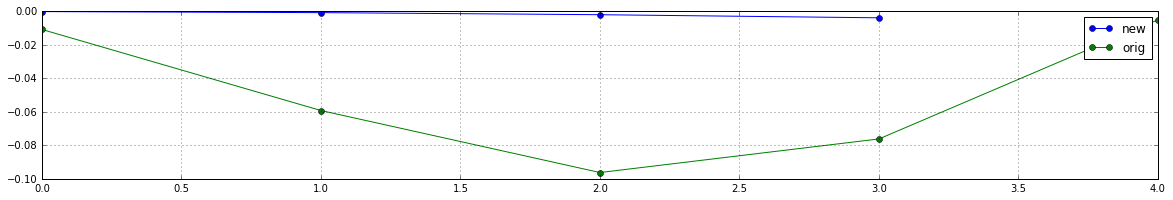

In [42]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'
utau, vtau = functions_plot.load_model_other(path, 'eventA')
fig, ax = plt.subplots(1,1,figsize=(20,3))
ax.plot(utau[0:5,-1,-1], marker='o', label='new'); ax.plot(utau_o[0:5,-1,-1], marker='o', label='orig')
ax.legend(); ax.grid()

# Upwelling Event B

* 0.15 impulse lasting 6 hours with upwelling event starting at about the 11th day
* after impulse, wind stress drops to 0.05 for 3 days and then 0

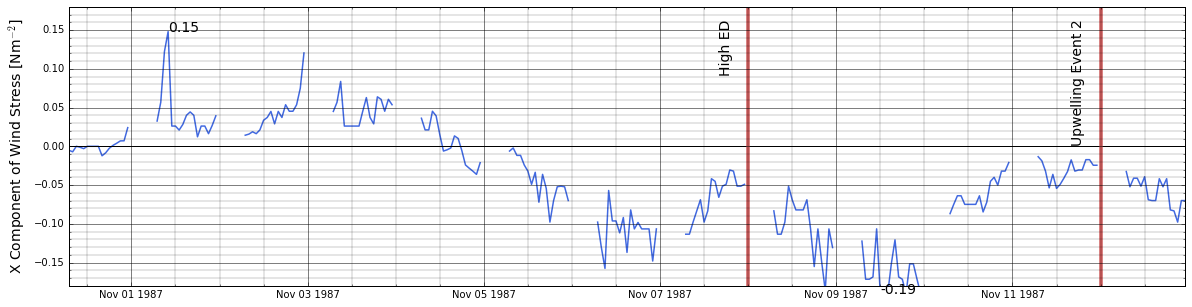

In [10]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
data_list = [oct87, nov87]
start_list = [31,1]
end_list = [31,12]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax = plot_range(ax, date_all, stress_all, -0.18, 0.18)
ax = stress_max_min(ax, stress_all)
ax = upwelling_event(ax, date_all, 1987, 11, 12, 0, 'Upwelling Event 2', 8, 'upw', 0.15)
ax = upwelling_event(ax, date_all, 1987, 11, 8, 0, 'High ED', 8, 'upw', 0.15)
ax.grid(b=True, which='major', color='k', linestyle='-', linewidth=0.5)
ax.grid(b=True, which='minor', color='k', linestyle='-', linewidth=0.2)
ax.minorticks_on()

# Upwelling Event C

* 0.12 impulse lasting 36 hours with upwelling event starting at about the 9th day
* after impulse, wind stress drops to 0 with a few bumps
* relaxation starts on the 17th day

0.12 impulse lasting 36 hours with upwelling event starting at about the 9th day
after impulse, wind stress drops to 0 with a few bumps
relaxation starts on the 17th day


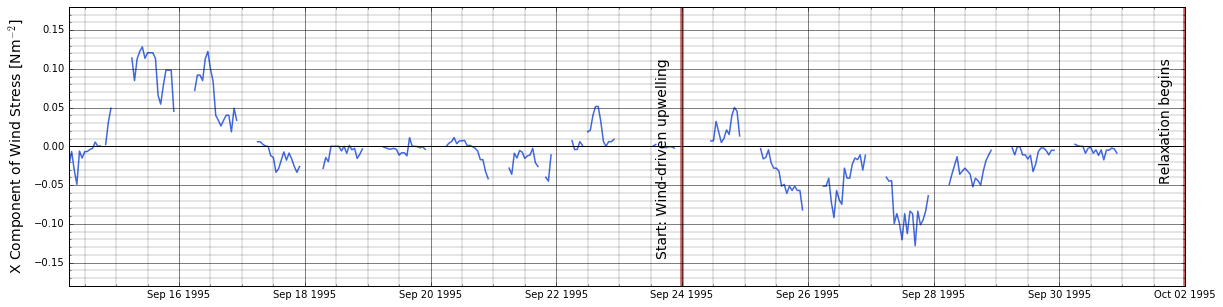

In [8]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
data_list = [sep95, oct95]
start_list = [14,1]
end_list = [30,5]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax = plot_range(ax, date_all, stress_all, -0.18, 0.18)
ax = upwelling_event(ax, date_all, 1995, 9, 24, 0, 'Start: Wind-driven upwelling', 10, 'upw', 0.10)
ax = upwelling_event(ax, date_all, 1995, 10, 2, 0, 'Relaxation begins', 10, 'upw', 0.10)
ax.grid(b=True, which='major', color='k', linestyle='-', linewidth=0.5)
ax.grid(b=True, which='minor', color='k', linestyle='-', linewidth=0.2)
ax.minorticks_on()